## Интеллектуальный анализ данных – весна 2021
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [147]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [148]:
X.isnull().any().any()
# пропущенных значений нет

False

In [149]:
print('Количество различных значений для каждого признака: ')
for el in X.columns:
    print(el, ': ', len(set(X[el])), sep='')

print('\n', '''Значений слишком много, поэтому категориальных признаков нет.
Если прочитать описание признаков, можно убедиться в том, что все они количественные.''', sep='')

Количество различных значений для каждого признака: 
alcohol: 126
malic_acid: 133
ash: 79
alcalinity_of_ash: 63
magnesium: 53
total_phenols: 97
flavanoids: 132
nonflavanoid_phenols: 39
proanthocyanins: 101
color_intensity: 132
hue: 78
od280/od315_of_diluted_wines: 122
proline: 121

Значений слишком много, поэтому категориальных признаков нет.
Если прочитать описание признаков, можно убедиться в том, что все они количественные.


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [154]:
from sklearn import preprocessing

normalizer = preprocessing.StandardScaler()
X_real_norm_np = normalizer.fit_transform(X_train)
X_train = pd.DataFrame(data=X_real_norm_np, columns = data['feature_names'])

X_real_norm_np = normalizer.transform(X_test)
X_test = pd.DataFrame(data=X_real_norm_np, columns = data['feature_names'])

X_train = X_train[['alcohol', 'magnesium']]
X_test = X_test[['alcohol', 'magnesium']]

In [155]:
# удаление выбросов в тренировочной выборке
# они были найдены вручную с помощью графиков задания 1.5
X_train = X_train.drop(65)
X_train = X_train.drop(113)
X_train = X_train.drop(114)
y_train = np.delete(y_train, 65, 0)
y_train = np.delete(y_train, 113, 0)
y_train = np.delete(y_train, 114, 0)

In [156]:
from sklearn.neighbors import KNeighborsClassifier
nn = [1, 3, 5, 10, 15, 25]
results = pd.DataFrame(columns=['NN', 'Train', 'Test', 'MSE'])
res = dict()
for el in nn:
    # адаптированный код из тетрадки к семинару 5
    clf = KNeighborsClassifier(n_neighbors=el)
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    y_predicted_train = clf.predict(X_train)
    res[el] = [y_predicted_train, y_predicted]
    results = results.append(pd.DataFrame([[el, round(np.mean(y_train==y_predicted_train), 2), 
                                            round(np.mean(y_test==y_predicted), 2), 
                                            np.square(y_test - y_predicted).mean(axis=None)]], 
                                          columns=['NN', 'Train', 'Test', 'MSE']), ignore_index=True)


results

,NN,Train,Test,MSE
0,1,0.99,0.69,0.703704
1,3,0.78,0.67,0.611111
2,5,0.76,0.65,0.629630
3,10,0.74,0.67,0.722222
4,15,0.74,0.65,0.740741
5,25,0.72,0.70,0.629630


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [37]:
!pip install mlxtend

  Using cached mlxtend-0.18.0-py2.py3-none-any.whl (1.3 MB)
     |████████████████████████████████| 10.0 MB 1.6 MB/s ta 0:00:01
  Using cached scipy-1.6.1-cp37-cp37m-macosx_10_9_x86_64.whl (30.7 MB)
     |████████████████████████████████| 8.5 MB 1.2 MB/s eta 0:00:01     |██████████▊                     | 2.8 MB 2.6 MB/s eta 0:00:03
     |████████████████████████████████| 16.0 MB 2.4 MB/s eta 0:00:01
  Using cached scikit-learn-0.24.1.tar.gz (7.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 303 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 948 kB/s eta 0:00:01
  Created wheel for scikit-learn: filename=scikit_learn-0.24.1-cp37-cp37m-macosx_10_11_x86_64.whl size=7072858 sha256=84f402411d4dabd9a6cb3d7c146a4b12d9810584d60056eea57ea75505c44382
  Stored in directory: /Users/katyona/Library/Caches/pip/wheels/db/eb/4d/cac8b821bb3ff0b962221b50c6d1

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [8]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

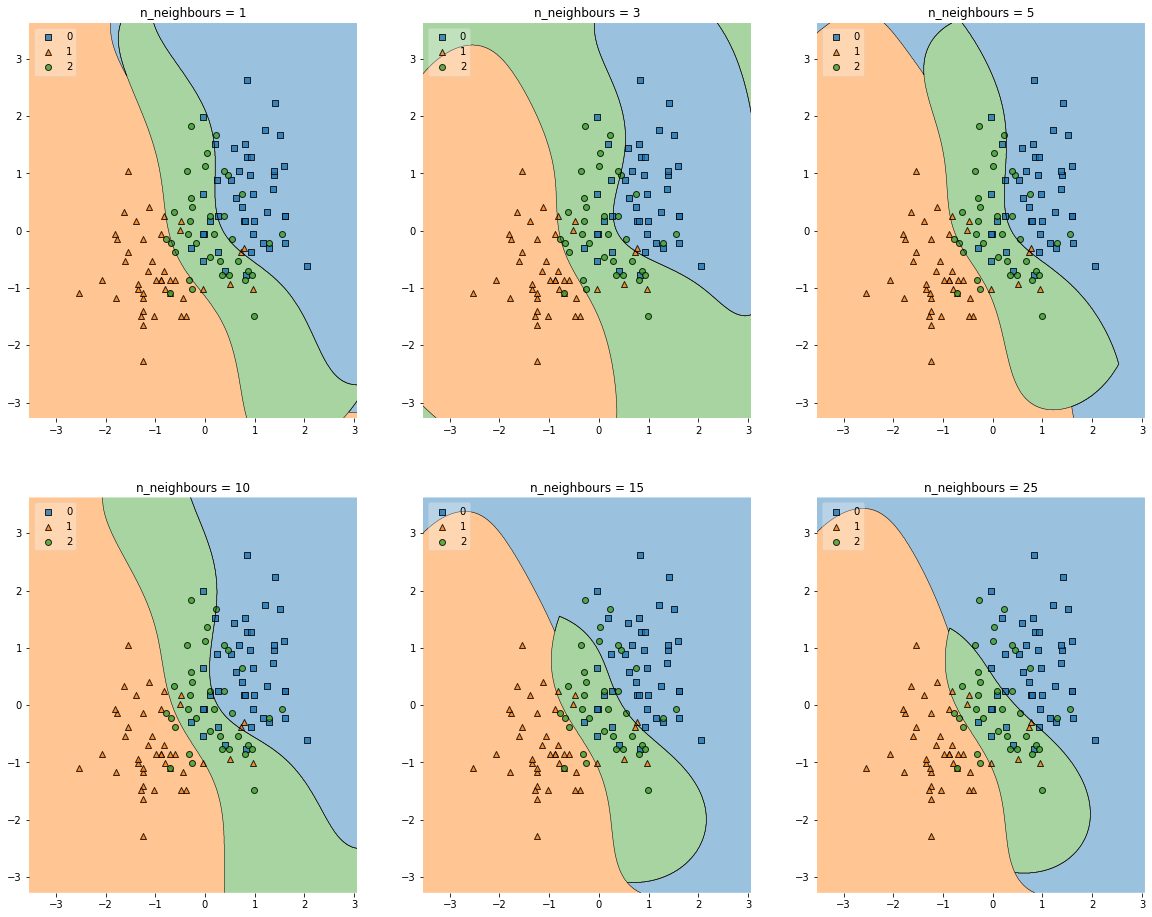

In [157]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Plotting decision regions
fig, axarr = plt.subplots(2, 3, figsize=(20,16), sharex=True, sharey=True)
values = nn
width = 0.75
for value, ax in zip(values, axarr.flat):
    svm = SVC(gamma='auto')
    svm.fit(X_train, res[value][0])
    plot_decision_regions(X_train.to_numpy(), y_train, clf=svm,
                          filler_feature_values={2: value},
                          filler_feature_ranges={2: width},
                          legend=2, ax=ax)
    ax.set_title('n_neighbours = {}'.format(value))

# Adding axes annotations
plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей
оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

**Ответ:**
По значению accuracy самый точный результат на тренировочной выборке наблюдается при k=3, следующее по точности значение при k=5. 
При этом визуально лучший результат дало обучение с k=10, так как все зоны расположены ровно, ни одна не "заползает" на другую, по-моему, это выглядит наиболее правдоподобно.

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

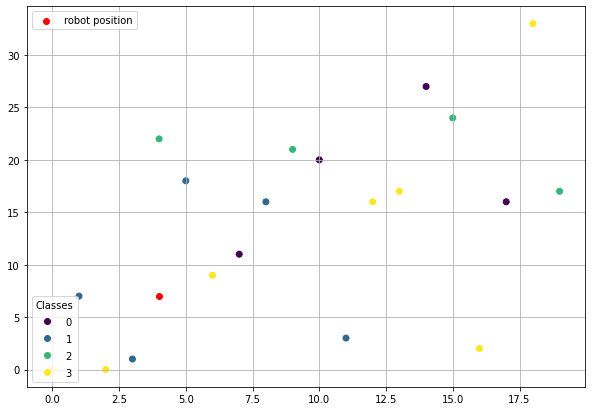

In [119]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [421]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        # int, Number of neighbours
        self.k = k 
        
        # ndarray, Initial position of the robot as a point, e.g. (-1, 1)
        self.initial_position = initial_position
        
        # ndarray, numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        self.landmarks = landmarks
        
        # ndarray, numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        self.classes = classes

        # Store the history of movements
        self.trajectory = np.array([initial_position])
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=self.k)
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        move_id = int(np.random.binomial(1, 0.2, 1))
        if move_id:
            # дополняем траекторию
            new_position = np.array([self.mapping[0]]) + np.array([self.trajectory[-1]])
            self.trajectory = np.concatenate((self.trajectory, new_position), axis=0)
        else:
            # обучение классификатора
            self.knn.fit(self.landmarks, self.classes)
            # вычисляем позицию, вокруг которой будем рассматривать соседей
            position = np.array([self.trajectory[-1]])
            # предсказываем класс объекта
            predicted = self.knn.predict(position)
            # ищем новые координаты
            new_position = np.array([self.mapping[predicted[0]]]) + np.array([self.trajectory[-1]])
            # дополняем траекторию
            self.trajectory = np.concatenate((self.trajectory, new_position), axis=0)
            

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [422]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    # траектория робота хранилась у него в атрибутах
    traj = robot.trajectory
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

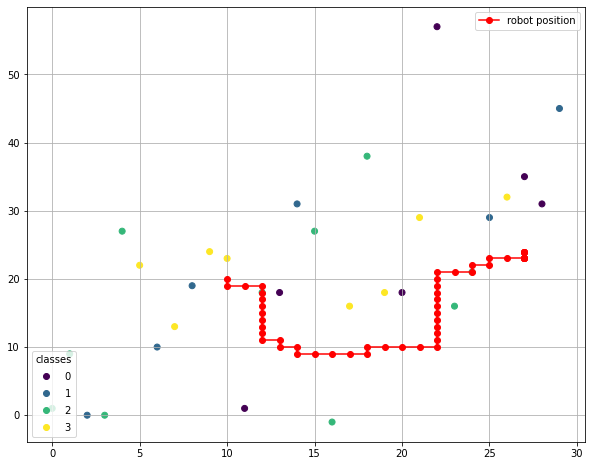

In [423]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

**Ответ:**

1) Как число соседей влияет на траекторию движения робота в нашем эксперименте? 
Чем больше соседей, тем больше робот двигается в одну сторону, в тех случаях, где он двигается в зависимости от соседей, так как его k ближайших соседей за один проделанный шаг меняются менее значительно. То есть при больших k "состав" соседей робота за один шаг изменится меньше, чем при малых k.

2) А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно?
Тогда 20% своего пути робот шел бы направо, а направление всех шагов, сделанных в соответствии с классами ближайших соседей, зависело бы от того класса, где он находится.

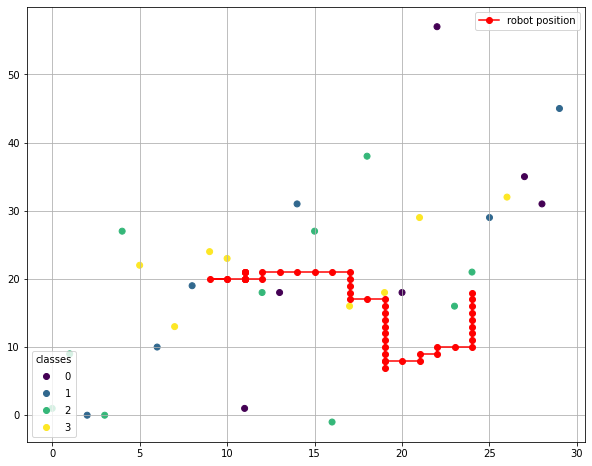

In [426]:
# 1 сосед
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 1, n_movements = 50)

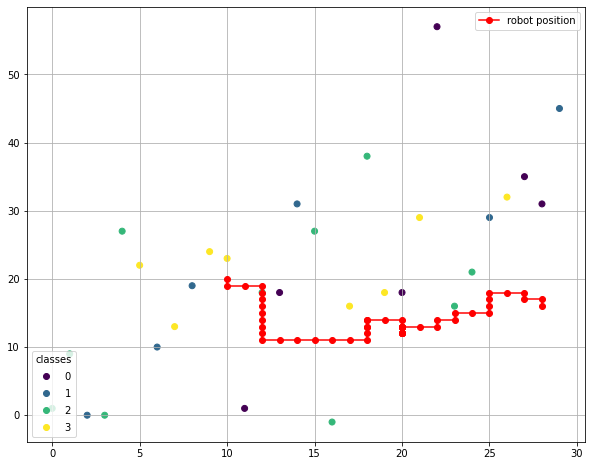

In [435]:
# 10 соседей
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 10, n_movements = 50)

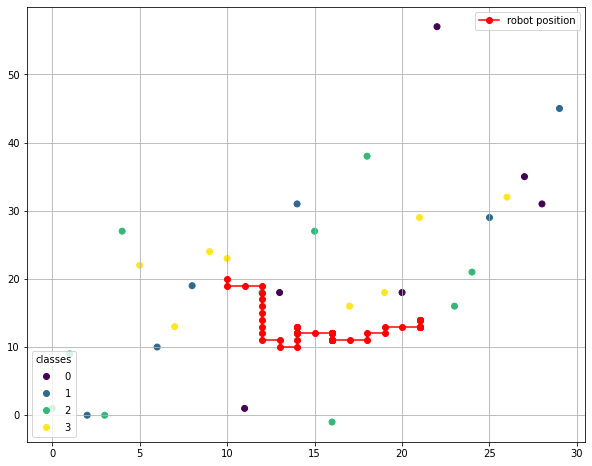

In [427]:
# 15 соседей
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 15, n_movements = 50)

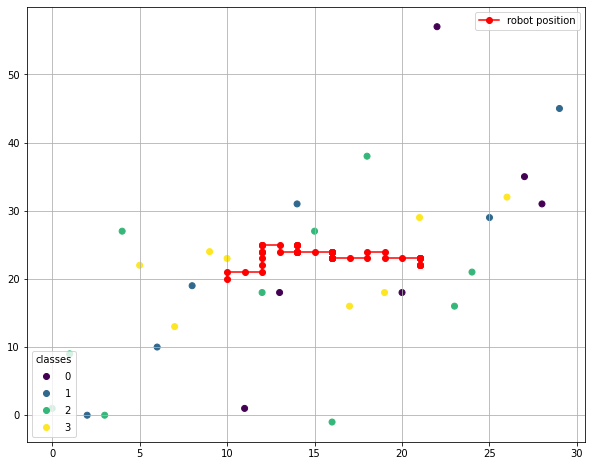

In [429]:
# 25 соседей
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 25, n_movements = 50)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [256]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [257]:
data.isnull().values.any()

False

**Ответ:**
пропущенных значений нет

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

Удалим столбец с индексами, так как он нам не понадобится

In [258]:
data = data.drop(columns=['Unnamed: 0'])
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [259]:
data[['price', 'carat', 'depth', 'table','x', 'y', 'z']].corr()['price'][:]

price    1.000000
carat    0.921591
depth   -0.010647
table    0.127134
x        0.884435
y        0.865421
z        0.861249
Name: price, dtype: float64

**Ответ:**
Больше всего с целевой переменной коррелирует вес бриллианта (carat), на втором месте - его размеры (x, y, z).

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [260]:
# список категориальных переменных
cat_features = ['cut', 'color', 'clarity']

for el in cat_features:
    rated_dummies = pd.get_dummies(data[el])
    data = pd.concat([data, rated_dummies], axis=1)
    data = data.drop(el, axis=1)

data.head(10)

,carat,depth,table,price,x,y,z,Fair,Good,Ideal,...,I,J,I1,IF,SI1,SI2,VS1,VS2,VVS1,VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0
5,0.24,62.8,57.0,336,3.94,3.96,2.48,0,0,0,...,0,1,0,0,0,0,0,0,0,1
6,0.24,62.3,57.0,336,3.95,3.98,2.47,0,0,0,...,1,0,0,0,0,0,0,0,1,0
7,0.26,61.9,55.0,337,4.07,4.11,2.53,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0.22,65.1,61.0,337,3.87,3.78,2.49,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0.23,59.4,61.0,338,4.00,4.05,2.39,0,0,0,...,0,0,0,0,0,0,1,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [261]:
X = data.drop(columns=['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [262]:
normalizer = preprocessing.StandardScaler()
real_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']

X_real_norm_np = normalizer.fit_transform(X_train[real_cols])
X_real_norm = pd.DataFrame(data=X_real_norm_np, columns=real_cols)
X_train = X_train.reset_index()
X_train = X_train.drop(['index'], axis=1)
X_train = pd.concat([X_real_norm, X_train.drop(columns=real_cols)], axis=1)

X_real_norm_np = normalizer.transform(X_test[real_cols])
X_real_norm = pd.DataFrame(data=X_real_norm_np, columns=real_cols)
X_test = X_test.reset_index()
X_test = X_test.drop(['index'], axis=1)
X_test = pd.concat([X_real_norm, X_test.drop(columns=real_cols)], axis=1)


**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [272]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train.to_numpy(), y_train.to_numpy())

res_train = round(np.square(y_train.to_numpy() - reg.predict(X_train.to_numpy())).mean(axis=None), 2)
res_test = round(np.square(y_test.to_numpy() - reg.predict(X_test.to_numpy())).mean(axis=None), 2)


result = pd.DataFrame({'Train': [res_train], 
                       'Test': [res_test]}, 
                      index=['MSE'])

result

,Train,Test
MSE,1268915.21,1303396.89


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [305]:
for col, el in zip(list(X_train.columns), list(reg.coef_)):
    print('{}:  {:.2f}'.format(col, el))
print('\nIndependent_term:  {:.2f}'.format(reg.intercept_))

carat:  5249.96
depth:  -72.90
table:  -68.61
x:  -965.89
y:  84.58
z:  -237.23
Fair:  -799609395437635.25
Good:  -799609395437010.62
Ideal:  -799609395436774.12
Premium:  -799609395436844.25
Very Good:  -799609395436872.62
D:  2453462611006305.50
E:  2453462611006098.00
F:  2453462611006032.00
G:  2453462611005827.00
H:  2453462611005335.00
I:  2453462611004857.50
J:  2453462611003973.50
I1:  -913535103132289.25
IF:  -913535103126927.50
SI1:  -913535103128586.88
SI2:  -913535103129545.88
VS1:  -913535103127669.00
VS2:  -913535103127984.12
VVS1:  -913535103127246.00
VVS2:  -913535103127308.12

Independent_term:  -740318112436675.00


**Ответ:**
Вещественные переменные, оценки которых по модулю на порядок превышают оценки других вещественных переменных: carat, x, z. 

Оценки всех категориальных признаков по модулю на порядок превышают оценки вещественных признаков.

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [304]:
# Lasso-регрессия
from sklearn.linear_model import Lasso
clf = Lasso(alpha=10)
clf.fit(X_train, y_train)
Lasso(alpha=10)
for col, el in zip(list(X_train.columns), list(clf.coef_)):
    print('{}:  {:.2f}'.format(col, el))
print('\nIndependent_term:  {:.2f}'.format(clf.intercept_))

carat:  4814.64
depth:  -89.05
table:  -86.45
x:  -528.09
y:  -0.00
z:  -208.76
Fair:  -468.79
Good:  -22.12
Ideal:  80.99
Premium:  0.00
Very Good:  0.00
D:  320.14
E:  156.25
F:  104.09
G:  -0.00
H:  -442.34
I:  -847.35
J:  -1616.65
I1:  -3562.67
IF:  665.50
SI1:  -630.36
SI2:  -1529.81
VS1:  160.48
VS2:  -18.94
VVS1:  516.16
VVS2:  503.46

Independent_term:  4380.64


**Ответ:**
После обучения с Lasso-регрессией веса вещественных признаков изменились, но не настолько сильно, как веса категориальных признаков.

In [306]:
# Ridge-регрессия
from sklearn.linear_model import Ridge
clf = Ridge(alpha=10)
clf.fit(X_train, y_train)
Ridge(alpha=10)
for col, el in zip(list(X_train.columns), list(clf.coef_)):
    print('{}:  {:.2f}'.format(col, el))
print('\nIndependent_term:  {:.2f}'.format(clf.intercept_))

carat:  5231.43
depth:  -71.21
table:  -67.92
x:  -908.56
y:  72.26
z:  -246.85
Fair:  -611.52
Good:  16.69
Ideal:  252.96
Premium:  184.57
Very Good:  157.29
D:  805.38
E:  602.24
F:  538.38
G:  340.66
H:  -159.15
I:  -629.25
J:  -1498.26
I1:  -3770.54
IF:  1499.00
SI1:  -151.77
SI2:  -1106.69
VS1:  765.83
VS2:  451.53
VVS1:  1186.84
VVS2:  1125.80

Independent_term:  3352.30


**Ответ:**
Веса вещественных переменных после обучения с Ridge-регрессией изменились гораздо менее значительно, чем с Lasso-регрессией, а вот веса категориальных признаков поменялись приблизительно так же (все они по модулю находятся в пределах 4000).

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

**Ответ:**
Агрессивнее всего уменьшает веса метод Lasso: при α=200 ненулевыми оказались только вес свободного коэффициента и вес признака с наибольшей корреляцией (carat). На графиках видно: график для Lasso-регрессии гораздо быстрее убывает.

Lasso-регрессию используют чаще для отбора признаков, тк она быстрее всего занудяет веса, откуда становится понятно, какие признаки имеют бОльшую корреляцию с целевой переменной, а какие признаки влияют на нее не столько значительно или вообще не влияют на нее.

In [322]:
# Lasso
alphas = [0.1, 1, 10, 100, 200]
lasso_norms = []
for a in alphas:
    clf = Lasso(alpha=a, max_iter=1000000000)
    clf.fit(X_train, y_train)
    Lasso(alpha=a)
    weights = np.append(clf.coef_, clf.intercept_)
    lasso_norms.append(np.linalg.norm(weights))

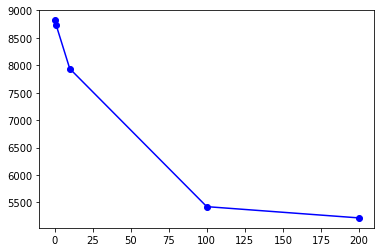

In [328]:
import matplotlib.pyplot as plt

plt.plot(alphas, lasso_norms, 'bo-')

plt.show()

In [326]:
alphas = [0.1, 1, 10, 100, 200]
ridge_norms = []
for a in alphas:
    clf = Ridge(alpha=a)
    clf.fit(X_train, y_train)
    Ridge(alpha=a)
    weights = np.append(clf.coef_, clf.intercept_)
    ridge_norms.append(np.linalg.norm(weights))

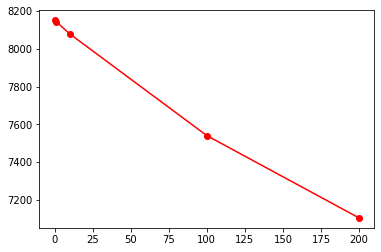

In [329]:
plt.plot(alphas, ridge_norms, 'ro-')
plt.show()

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [349]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=0, alphas=alphas, max_iter=1000000000).fit(X_train, y_train)
df = pd.DataFrame(data=np.around(reg.mse_path_.mean(axis=1), 2), index=reg.alphas_, columns=['mean'])
df = df.reset_index()
df.rename(columns={'index': 'alpha'})

,alpha,mean
0,200.0,2413829.96
1,100.0,2197445.39
2,10.0,1308720.31
3,1.0,1272684.78
4,0.1,1272761.72


**Ответ:**
Наилучший результат при α=1, поэтому выберем это значение.

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [350]:
reg = LassoCV(cv=5, random_state=0, alphas=[1], max_iter=1000000000).fit(X_train, y_train)
weights = np.append(reg.coef_, reg.intercept_)
for col, el in zip(list(X_train.columns)+['Independent_term'], list(weights)):
    print('{}:  {:.2f}'.format(col, el))

carat:  5230.22
depth:  -80.44
table:  -69.60
x:  -890.19
y:  0.00
z:  -195.56
Fair:  -740.89
Good:  -129.54
Ideal:  91.77
Premium:  19.51
Very Good:  0.00
D:  453.42
E:  253.30
F:  190.54
G:  0.00
H:  -495.05
I:  -961.91
J:  -1828.09
I1:  -4317.60
IF:  935.45
SI1:  -689.81
SI2:  -1643.19
VS1:  217.17
VS2:  -85.38
VVS1:  632.43
VVS2:  575.39
Independent_term:  4396.42


**Ответ:**
Наибольшее влияние на цену алмаза оказывает его вес, так как значение веса для этого параметра является самым большим по модулю.

Если смотреть относительно весов остальных признаков, незначительными признаками оказались глубина (depth), ширина плоской поверхности (table) и ширина бриллианта (y). 

Порядковый признак огранка (cut) оказался информативным - среднее значение (very good) никак не отражается на цене, при этом все значения ниже среднего уменьшают цену, а выше среднего - увеличивают. 

Точно такая же ситуация с цветом (color): при движении от бесцветного D к желтому J влияние на цену сменяется с положительного на отрицательное.

{I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF} - clarity от наихудшего к наилучшему показателю

Признак чистота (clarity) оказывает точно такое же влияние на цену алмаза: чем больше включений (значения слева), тем меньше цена, чем чище бриллиант (значения правее), тем дороже он стоит.

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [354]:
res_test_new = round(np.square(y_test.to_numpy() - reg.predict(X_test.to_numpy())).mean(axis=None), 2)
df = pd.DataFrame({"Ordinary_reg_MSE": [res_test], "New_reg_MSE": [res_test_new]}, index=['MSE'])
df

,Ordinary_reg_MSE,New_reg_MSE
MSE,1303396.89,1301366.37


**Ответ:**
Итоговая Lasso-регрессия с выбранным параметром α=1 по среднеквадратической ошибке показала результат лучше, чем обычная линейная регрессия из задачи 3.7. Это связано с тем, что обучение проходит с использованием кросс-валидации и регуляризатора, что помогает избежать переобучения и его "симптома" - больших коэффициентов. При больших коэффициентах, несоразмерных со значениями целевой переменной, при изменении признаков на небольшое значение результат будет дальше "съезжать" от правильного. Поэтому среднеквадратическая ошибка будет больше, чем применьших весах.

  